# Test Shell interaction - 

### Interacting shells. When one inside the other, no force, outside, Newton, crossover is shown in graph.

# LINEAR DROP in force with distance for overlapping shells in the region of overlap


In [2]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
%load_ext Cython 




## Force calc
### get netX, nety, netz, then force between them is m1*m2/d^2, to get vectors, we use netx/dist to get x contribution, etc.

In [3]:
%%cython
import numpy as np
import time
cimport cython
cimport numpy as cnp
cnp.import_array()

from libc.math cimport sqrt
from libc.math cimport isnan




cdef double oneOverroot3 = 0.57735026918962576450914878050195
cdef double oneOverroot2 = 0.7071067811865475244008443621048

#     # mass function
#     # mass density in my model is slightly altered from the one in the Katz paper.
#     # start with equation 3, take derivative, then get '
#     # https://www.wolframalpha.com/input?i=derivative+of+M+-+M%2F%281+%2B+2x%2FM%29+
#     # then divide by area of a sphere to get my mass density. 
#     # https://www.wolframalpha.com/input?i=%282M%5E2%2F%28M+%2B+2x%29%5E2%29%2F%284*pi*x%5E2%29
#     # then we have
#     # total mass is m, total radius is rS, so each particle we have represents 1/(4/3pirS^3) worth of volume. 
#     # we take the mass density (say a constant or by formula) and mult by the volume to get the mass of each particle.

# cdef double massOfPointConstantDensity(double m, double volS, int numPoints):
#     cdef double volPerPoint = volS/(numPoints*numPoints*numPoints)
#     return m/volS*volPerPoint # constant density, 

# return mass density at r * volperpoint
@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
# cdef double massOfPointLocalEnergy(double r, double m, double volS, int numPoints):
#     cdef double volPerPoint = volS/(numPoints*numPoints*numPoints)
#     return m*m/(2*np.pi*r*r*(m + 2*r)*(m + 2*r))*volPerPoint

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cdef double massOfPointInMassiveShell(double r, double m, double rS, double cellSize):
    if rS - r < 1.2*cellSize:
        return m
    return 0

# cdef massOfPointConstantDensity(double r, double m, double volS):
#     volPerPoint = volS/(numPoints*numPoints*numPoints)
#     return m/volS*volPerPoint # constant density, 


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cpdef doTheWork(long numPoints, double rS1, double m1, double rS2, double m2, double minDist, double maxDist, long dRes):
    # idea - make two spheres, each with points that vary in mass with radius
    # mass points are on non interecting planes of z 
    # masses are held apart in x direction, moved together.
    # both spheres have same number of points, just masses of each point varies 
    # points in an XY plane are laid out in grid, with no points at r > r of sphere 
    # (keeping in mind where each sphere has an origin at: 0 0 0 
    
    cdef double volS1 = (4/3*np.pi*rS1*rS1*rS1)
    cdef double volS2 = (4/3*np.pi*rS2*rS2*rS2)
    cdef double cellSize1 = rS1/(2*numPoints)
    cdef double cellSize2 = rS2/(2*numPoints)

    cdef long maxNumberOfMassPoints = (numPoints)*(numPoints)*(numPoints)

    cdef cnp.ndarray[double] s1x = np.empty(maxNumberOfMassPoints, dtype=np.double)
    cdef cnp.ndarray[double] s1y = np.empty(maxNumberOfMassPoints, dtype=np.double)
    cdef cnp.ndarray[double] s1z = np.empty(maxNumberOfMassPoints, dtype=np.double)
    cdef cnp.ndarray[double] s1m = np.empty(maxNumberOfMassPoints, dtype=np.double)
    cdef cnp.ndarray[double] s2x = np.empty(maxNumberOfMassPoints, dtype=np.double)
    cdef cnp.ndarray[double] s2y = np.empty(maxNumberOfMassPoints, dtype=np.double)
    cdef cnp.ndarray[double] s2z = np.empty(maxNumberOfMassPoints, dtype=np.double)
    cdef cnp.ndarray[double] s2m = np.empty(maxNumberOfMassPoints, dtype=np.double)
    
    # make the masses as distributed points 
    cdef double com1X = 0;
    cdef double com1Y = 0;
    cdef double com1Z = 0;
    cdef double com2X = 0;
    cdef double com2Y = 0;
    cdef double com2Z = 0;
    cdef double totalMass1 = 0
    cdef double totalMass2 = 0
    cdef double r = 0
    cdef double x = 0
    cdef double y = 0
    cdef double z = 0
    cdef double m = 0
    cdef long np1 = 0
    for x in np.linspace(-rS1, rS1, numPoints):
        for y in np.linspace(-rS1, rS1, numPoints):
            for z in np.linspace(-rS1, rS1, numPoints):
                r = sqrt(x*x + y*y + z*z)
                if r < rS1:
                    #add a point to each
                    # mass 
                    m = massOfPointInMassiveShell(r, m1, rS1, cellSize1)
                    # m = massOfPointLocalEnergy(r, m1, volS1, numPoints)
                    if isnan(m):
                        print("m is nan", r, m1, volS1, numPoints)
                    if m > 0:
                        totalMass1 += m
                        s1x[np1] = x
                        s1y[np1] = y
                        s1z[np1] = z
                        s1m[np1] = m
                        np1 += 1
                        com1X += m*x
                        com1Y += m*y
                        com1Z += m*z
                    
    cdef long np2 = 0
    for x in np.linspace(-rS2, rS2, numPoints):
        for y in np.linspace(-rS2, rS2, numPoints):
            for z in np.linspace(-rS2, rS2, numPoints):
                r = sqrt(x*x + y*y + z*z)
                if r < rS2:
                    #add a point to each
                    # mass                 
                    m = massOfPointInMassiveShell(r, m2, rS2, cellSize2)
                    #m = massOfPointLocalEnergy(r, m2, volS2, numPoints)
                    if m > 0:
                        totalMass2 += m
                        s2x[np2] = x
                        s2y[np2] = y
                        s2z[np2] = z
                        s2m[np2] = m
                        np2 += 1
                        com2X += m*x
                        com2Y += m*y
                        com2Z += m*z
    
        
    print('centre of mass 1:',com1X, com1Y, com1Y)
    print('centre of mass 2:',com2X, com2Y, com2Y)
    print('total mass 1:',totalMass1)
    print('total mass 2:',totalMass2)
    print('MaxNumMassPoints:',maxNumberOfMassPoints)
    print('NumMassPoints:',np1, np2)
    
    # now we have our points in two numpy arrays, 
    # for each point, we want to figure out the forces and add them all up.

# Do the grunt work
    distances = np.linspace(minDist, maxDist, dRes)
    cdef long numDistances = distances.size
    cdef cnp.ndarray[double] forcesX = cnp.ndarray(numDistances, dtype=np.double)
    cdef cnp.ndarray[double] forcesY = cnp.ndarray(numDistances, dtype=np.double)
    cdef cnp.ndarray[double] forcesZ = cnp.ndarray(numDistances, dtype=np.double)
    cdef double cellSize = 2*max(cellSize1, cellSize2)
    print("cellSize",cellSize , cellSize1, cellSize2)
    cdef double s1xn = 0
    cdef double s1yn = 0
    cdef double s1zn = 0
    cdef double s1mn = 0
    cdef long distCount = 0
    cdef double d = 0
    cdef long n1 = 0
    cdef long n2 = 0
    cdef double forceSumX = 0
    cdef double forceSumY = 0
    cdef double forceSumZ = 0
    cdef double netx
    cdef double nety
    cdef double netz
    cdef double massF
    cdef double dist
    cdef double dC
    cdef double totalFactor
    cdef long numCalcs = 0
    for d in distances:
        forceSumX = 0 # we sum into this little array
        forceSumY = 0
        forceSumZ = 0
        for n1 in range(np1):
            s1xn = s1x[n1]
            s1yn = s1y[n1]
            s1zn = s1z[n1]
            s1mn = s1m[n1]
            for n2 in range(np2):
                numCalcs += 1
                netx =  d*oneOverroot3 - s1xn + s2x[n2]
                nety =  d*oneOverroot3 - s1yn + s2y[n2]
                netz =  d*oneOverroot3 - s1zn + s2z[n2]
                massF = s1mn*s2m[n2]
                dist = sqrt(netx*netx + nety*nety + netz*netz)
                # from running this program, we know that once two cells start to overlap, the force goes 
                # down as dist goes to zero. This cellSize*cellSize/dist accomplishes that.
                if dist > 1e-12:
                    if dist < cellSize:
                        dist = cellSize*cellSize/dist# [0, 0, 0] #hack to not explode - ignore close points also try dist = cellSize #
                    dC = dist*dist*dist # we need cubed, one to normalize the vector, the other two to do Newton's force
                    totalFactor = massF/dC
                    if isnan(totalFactor*netx):
                        print("totalFactor is nan",totalFactor , massF, dC, netx)
                    forceSumX += totalFactor*netx
                    forceSumY += totalFactor*nety
                    forceSumZ += totalFactor*netz
        forcesX[distCount] = forceSumX
        forcesY[distCount] = forceSumY
        forcesZ[distCount] = forceSumZ
        distCount += 1
        print("*", end="")


    # output use regular array (list)
    #print('forcesX:',forcesX)

    #cdef cnp.ndarray[double, ndim=2] 
    # cdef cnp.ndarray[double, ndim=2] forces = cnp.ndarray(dtype=np.double, ndim=2)
    # forces.append(forcesX)
    # forces.append(forcesY)
    # forces.append(forcesZ)
    
    # print('force distances:',len(forces))
    # print('forces per distance:',len(forces[0]))
    #print('force:',np.sum(forces[34][0]))
    print("!")
    return numCalcs, forcesX, forcesY, forcesZ, distances, totalMass1, totalMass2




## Settings: Thin shell:
# I set resolution to res (say 70), so res**3 points in a cube are checked, if a point is near the surface, 
# it's included in the shell, with 1.2*cellSize seemingly optimal for shell thickness. 
#
## Result: as the shell crosses, (an r = 20 sized shell overlapping an r = 100 shell) the force 
# DROPS linearly with distance during the overlap (ie from d = 120 to d = 80) (the force really looks linear if dM is set to d^2 in code so the normal newton force is a flat line, and thus the graph shows deviations from a newton force.

r1 = 100
m1 = 1
r2 = 20
m2 = 1
resolution = 70
# keep min dist and max dist odd weird numbers so points dont hit each other
minDist = 0.12129876523
maxDist = 200.2212123123
dRes = 300



centre of mass 1: -1.4779288903810084e-12 3.097966327914037e-12 3.097966327914037e-12
centre of mass 2: 1.4210854715202004e-12 3.40349970429088e-12 3.40349970429088e-12
total mass 1: 4152.0
total mass 2: 4152.0
MaxNumMassPoints: 343000
NumMassPoints: 4152 4152
cellSize 1.4285714285714286 0.7142857142857143 0.14285714285714285
************************************************************************************************************************************************************************************************************************************************************************************************************!
dotheWork took: 19.2009379863739
million per sec:  269.3481457766264
billion Calcs:  5.1717312
totalForce0: 9572.716204445756
totalForce40: 6878.274967054239


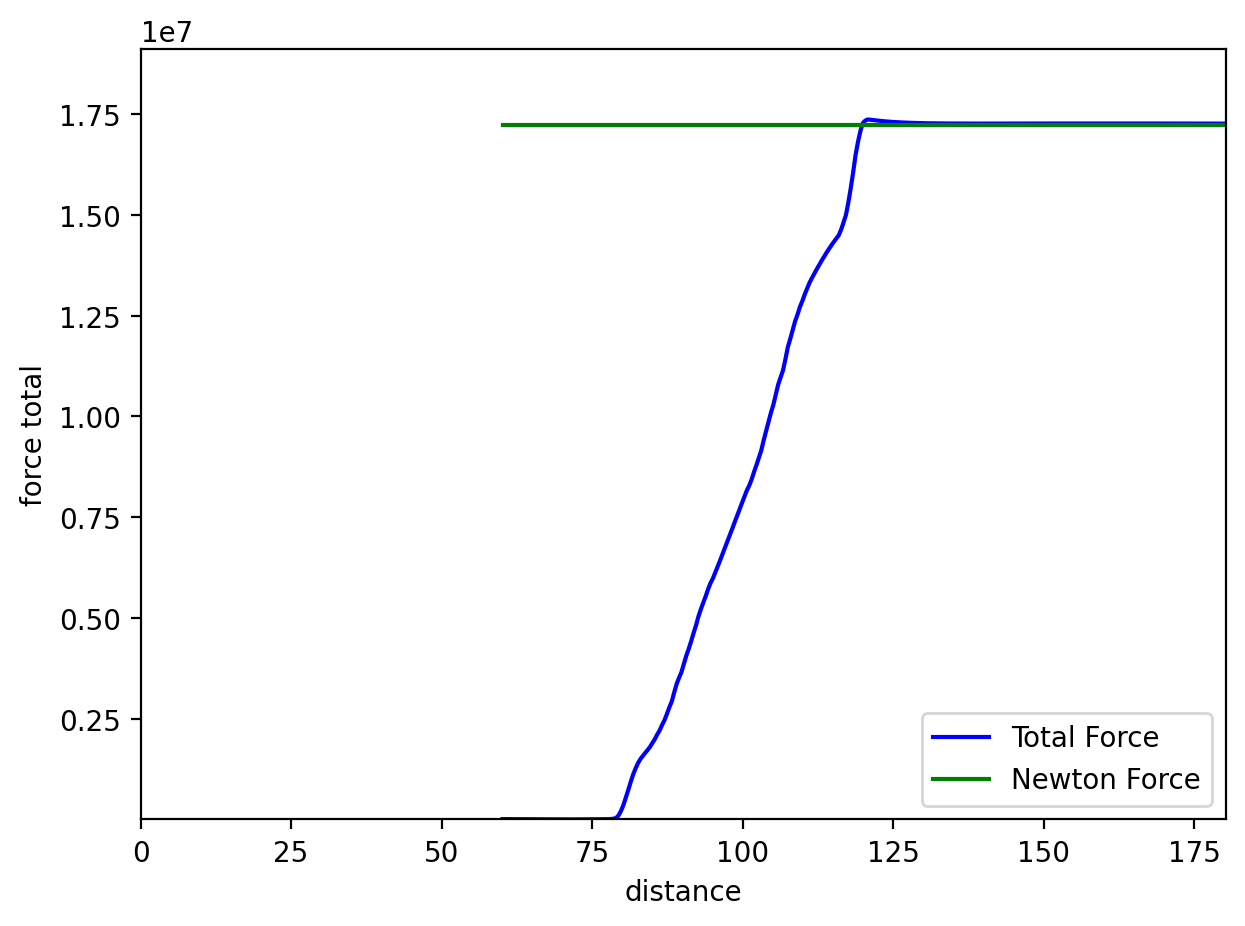

In [4]:
#my formula for mass inside of d/2
def calcBirkhoff(d, m1, m2):
    rTouch = d/2
    m1Inside = m1 - m1/(1 + 2*rTouch/m1)
    m2Inside = m2 - m2/(1 + 2*rTouch/m2)
    force = m1Inside*m2Inside/(d*d)
    return force

r1 = 100
m1 = 1
r2 = 20
m2 = 1
resolution = 70
# keep min dist and max dist odd weird numbers so points dont hit each other
minDist = 60.12129876523
maxDist = 180.2212123123
dRes = 300


start_time = time.time()
numCalcs, forcesX, forcesY, forcesZ, distances, mass1, mass2 = doTheWork(resolution, r1, m1, r2, m2, minDist, maxDist, dRes)
millionsPerSec = (numCalcs/1e6)/(time.time() - start_time)
print("dotheWork took:", (time.time() - start_time))
print("million per sec: ", millionsPerSec)
print("billion Calcs: ", numCalcs/1e9)


xForce = []
yForce = []
zForce = []
totalForce = []
maxForce = 0
minForce = 1e99
maxForceX = 0
minForceX = 1e99
maxForceZ = 0
minForceZ = 1e99
dCount = 0
newtonTotalForce = []
birkhoffTotalForce = [] # naive calculation based on mass inside of d/2
for d in distances:
    d2 = d*d
    dM = d2 # set to d2 to see errors from r^2, set dM to 1 to see actual r^2 graph
    #dM = 1
    # Sum along columns (axis=0) - get total x, y, z forces, which 
    # xyzNet = np.sum(fV, axis=0) 
    xT = forcesX[dCount]*dM
    yT = forcesY[dCount]*dM
    zT = forcesZ[dCount]*dM
    tF = np.sqrt(xT*xT + yT*yT + zT*zT)
    totalForce.append(tF)
    xForce.append(xT)
    yForce.append(yT)
    zForce.append(zT)
    maxForce = max(maxForce, tF)
    minForce = min(minForce, tF)
    maxForceX = max(maxForceX, xT)
    minForceX = min(minForceX, xT)
    maxForceZ = max(maxForceZ, zT)
    minForceZ = min(minForceZ, zT)
    newtonTotalForce.append(mass1*mass2*dM/(d*d))
    birkhoffTotalForce.append(calcBirkhoff(d, mass1, mass2)*dM)
    dCount += 1

maxDist = distances[-1]
np.savetxt('forces.csv', totalForce, delimiter=',')

if np.abs(minForce - maxForce)/maxForce < 0.001:
    minForce = 0.99999999999999*maxForce
    maxForce = 1.00000000000001*maxForce

if np.abs(minForceX - maxForceX)/maxForce < 0.001:
    minForceX = 0.99999999999999*maxForceX
    maxForceX = 1.00000000000001*maxForceX

if np.abs(minForceZ - maxForceZ)/maxForce < 0.001:
    minForceZ = 0.99999999999999*maxForceZ
    maxForceZ = 1.00000000000001*maxForceZ

# calculate some curves:


print('totalForce0:',totalForce[0])
print('totalForce40:',totalForce[40])

fig = plt.figure(figsize=(7, 5), dpi=200)
plt.plot(distances, totalForce, marker="none", color='blue', lw=1.5, label='Total Force')
plt.plot(distances, newtonTotalForce, marker="none", color='green', lw=1.5, label='Newton Force')
#plt.plot(distances, birkhoffTotalForce, marker="none", color='red', lw=1.5, label='Birkhoff Force')
plt.xlabel('distance');
plt.ylabel('force total');
plt.legend(loc='lower right')
plt.axis((0, maxDist, minForce*0.9, maxForce*1.1));
#plt.savefig('../chapters/images/force.png', bbox_inches='tight')
plt.show()


# fig = plt.figure(figsize=(7, 5), dpi=200)
# plt.plot(distances, xForce, marker="none", color='green', lw=1.5, label='Force')
# plt.xlabel('distance');
# plt.ylabel('force x');
# plt.legend(loc='lower right')
# plt.axis((0, maxDist, minForceX, maxForceX));
# #plt.savefig('../chapters/images/force.png', bbox_inches='tight')
# plt.show()


# fig = plt.figure(figsize=(7, 5), dpi=200)
# plt.plot(distances, yForce, marker="none", color='yellow', lw=1.5, label='ForceZ')
# plt.xlabel('distance');
# plt.ylabel('force z');
# plt.legend(loc='lower right')
# plt.axis((0, maxDist, minForceZ, maxForceZ));
# #plt.savefig('../chapters/images/force.png', bbox_inches='tight')
# plt.show()

## NOTE - in graph above i usually have the force normalized to a flat line...
# so one can see deviations from a normal 1/r^2 easier.
See the dM = 1 comment in the code... 